In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import string
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings

from IPython.display import display
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## DRILL: Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  

__Robbery and Murder__ are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  

Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

In [2]:
def load_crime_data(file):
    columns = ['City', 'Population', 'Violent crime',
    'Murder and nonnegligent manslaughter',
    'Rape (revised definition)', 'Rape (legacy definition)',
    'Robbery', 'Aggravated assault', 'property_crime', 'Burglary',
    'larceny_theft', 'Motor vehicle theft', 'Arson3']

    df = pd.read_csv(file, low_memory=False, dtype={'Population': int},  thousands=',',)
    df.columns = columns # original columns have \n etc
    
    # Create binary columns
    df['rape_binary'] = df['Rape (legacy definition)'].apply(lambda r: 1 if r > 0 else 0)
    df.drop(columns=['Rape (legacy definition)', 'Rape (revised definition)'], inplace=True)
    
    df['murder_binary'] = df['Murder and nonnegligent manslaughter'].apply(lambda m: 1 if m > 0 else 0)
    df.drop(columns=['Murder and nonnegligent manslaughter'], inplace=True)
    
    df['pop_squared'] = df['Population'].apply(lambda p: p**2)
    
#     df['property_crime'] = df['property_crime']**(1/1.3) # todo makea SEPERATE COLUMN FOR SCALED CRIME
# reference photo: https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/

    # Five cities (NYC) stand out as extreme population outliers, so we drop them.
    return df.drop(df[df.Population > 100000].index)

In [3]:
file = 'new_york_crime_2013.csv'
df = load_crime_data(file)

In [4]:
df.head()

City  Population  Violent crime  Robbery  \
0             Adams Village        1861              0        0   
1  Addison Town and Village        2577              3        0   
2             Akron Village        2846              3        0   
3                    Albany       97956            791      227   
4            Albion Village        6388             23        4   

   Aggravated assault  property_crime  Burglary  larceny_theft  \
0                   0              12         2             10   
1                   3              24         3             20   
2                   3              16         1             15   
3                 526            4090       705           3243   
4                  16             223        53            165   

   Motor vehicle theft  Arson3  rape_binary  murder_binary  pop_squared  
0                    0   0.000            0              0      3463321  
1                    1   0.000            0              0      6640929  
2                    0   0.000            0              0      8099716  
3                  142     nan            1              1   9595377936  
4                    5     nan            1              0     40806544

## Correlations

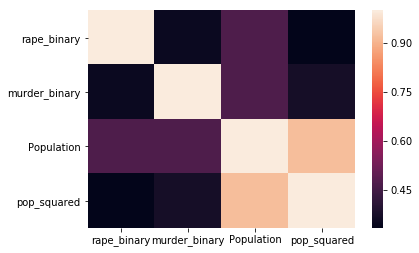

In [5]:
sns.heatmap(df[['rape_binary', 'murder_binary', 'Population', 'pop_squared']].corr())
plt.show()

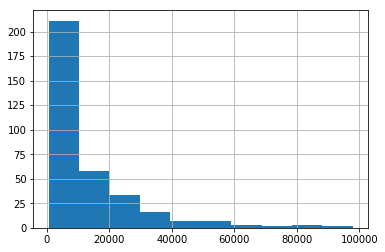

In [6]:
df['Population'].hist()

# Create Linear Regression Model -- 2.4.4
Use the given model in the problem statement:
$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

- ## Question: where did the author get that model?
- ## *Why does larceny_theft almost perfectly correlate with property crime?*

## Create and inspect model stats

In [7]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['property_crime'].values.reshape(-1, 1)
X = df[['rape_binary', 'murder_binary', 'Population', 'pop_squared'] + ['larceny_theft']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-3.16696954e+00  4.86772884e+01 -4.01452016e-04 -4.99316855e-09
   1.27019564e+00]]

Intercept: 
 [-4.46962488]

R-squared:
0.988901379864702


### `Larceny- theft` seems to correlate almost perfectly with `Property crime`... ?!

In [8]:
df.plot.scatter(x='property_crime',
                   y='larceny_theft',
                   c='Population',
                   colormap='viridis')

### Risiduals

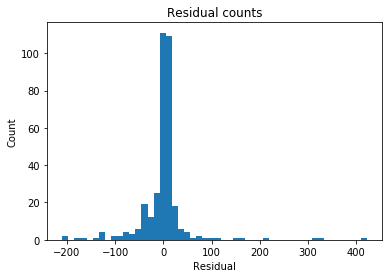

In [9]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, bins=50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## The model exhibits *heteroscedasticity* as population size increases
__Question__: how do I address this?

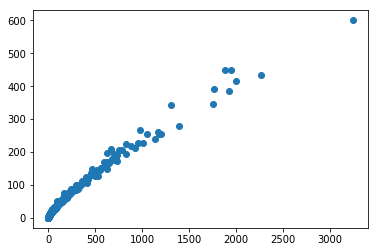

In [10]:
plt.scatter(df['larceny_theft'], df['property_crime']**(1/1.3))

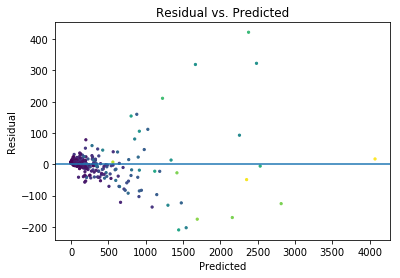

In [11]:
plt.scatter(predicted, residual, c=df['Population'], s=5)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Challenge: Validating a linear regression, 2.5.2
### Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. __In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.__

You'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include 
- other states crime rates in 2013 or 
- crime rates in New York State in other years or a combination of these.

### Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

## Check statistical significance of parameters

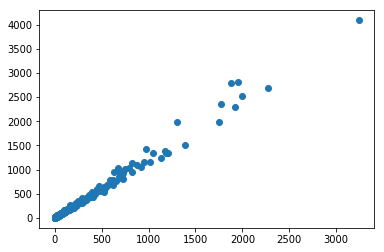

In [12]:
plt.scatter(df['larceny_theft'], df['property_crime'])

In [13]:
def create_lm(linear_formula, df):
    lm = smf.ols(formula=linear_formula, data=df).fit()
    print(f'\nParams:\n {lm.params}')
    print(f'\nPvalues:\n {lm.pvalues}')
    print(f'\nR^2:\n {lm.rsquared}')
    return lm

linear_formula = 'property_crime ~ rape_binary+murder_binary+Population+pop_squared+larceny_theft'
create_lm(linear_formula, df)


Params:
 Intercept       -4.470
rape_binary     -3.167
murder_binary   48.677
Population      -0.000
pop_squared     -0.000
larceny_theft    1.270
dtype: float64

Pvalues:
 Intercept       0.335
rape_binary     0.652
murder_binary   0.000
Population      0.451
pop_squared     0.447
larceny_theft   0.000
dtype: float64

R^2:
 0.9889013798647018


### We can drop `rape_binary` and `Population`/`pop_squared`

In [14]:
linear_formula = 'property_crime ~ murder_binary+larceny_theft'
lm = create_lm(linear_formula,  df)


Params:
 Intercept       -6.399
murder_binary   46.388
larceny_theft    1.242
dtype: float64

Pvalues:
 Intercept       0.057
murder_binary   0.000
larceny_theft   0.000
dtype: float64

R^2:
 0.9887282642238596


## Test on 2014 NY data

In [15]:
file_2014 = 'new_york_crime_2014.csv'
df_2014 = load_crime_data(file_2014)
df.head()

City  Population  Violent crime  Robbery  \
0             Adams Village        1861              0        0   
1  Addison Town and Village        2577              3        0   
2             Akron Village        2846              3        0   
3                    Albany       97956            791      227   
4            Albion Village        6388             23        4   

   Aggravated assault  property_crime  Burglary  larceny_theft  \
0                   0              12         2             10   
1                   3              24         3             20   
2                   3              16         1             15   
3                 526            4090       705           3243   
4                  16             223        53            165   

   Motor vehicle theft  Arson3  rape_binary  murder_binary  pop_squared  
0                    0   0.000            0              0      3463321  
1                    1   0.000            0              0      6640929  
2                    0   0.000            0              0      8099716  
3                  142     nan            1              1   9595377936  
4                    5     nan            1              0     40806544

In [16]:
linear_formula = 'property_crime ~ murder_binary+larceny_theft'
create_lm(linear_formula, df_2014)


Params:
 Intercept       -2.545
murder_binary   40.528
larceny_theft    1.216
dtype: float64

Pvalues:
 Intercept       0.380
murder_binary   0.000
larceny_theft   0.000
dtype: float64

R^2:
 0.9893328203658205


# 3.3.4 Challenge: Flavors of Logistic Regression
Pick a dataset of your choice with a binary outcome and the potential for at least 15 features. If you're drawing a blank, the crime rates in 2013 dataset has a lot of variables that could be made into a modelable binary outcome.

Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

- Vanilla logistic regression
- Ridge logistic regression
- Lasso logistic regression
If you're stuck on how to begin combining your two new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In your report, evaluate all three models and **decide on your best**. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the **strengths and limitations of regression as a modeling approach.** Were there things you couldn't do but you wish you could have done?

In [17]:
from sklearn.linear_model import LogisticRegression

## SKLearn

**penalty : str, ‘l1’ or ‘l2’, default: ‘l2’.** Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support **only l2** penalties.

**solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default: ‘liblinear’.**
Algorithm to use in the optimization problem.
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
**‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty**, whereas **‘liblinear’ and ‘saga’ handle L1 penalty.**
Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

In [18]:
df

City  Population  Violent crime  Robbery  \
0                 Adams Village        1861              0        0   
1      Addison Town and Village        2577              3        0   
2                 Akron Village        2846              3        0   
3                        Albany       97956            791      227   
4                Albion Village        6388             23        4   
5                Alfred Village        4089              5        3   
6              Allegany Village        1781              3        0   
8            Amityville Village        9519              9        4   
9                     Amsterdam       18182             30       12   
10               Arcade Village        2053              0        0   
11              Ardsley Village        4523              5        3   
12            Asharoken Village         658              0        0   
13               Attica Village        2522              2        0   
14                       Auburn       27270             96       22   
15                 Avon Village        3333              1        1   
16        Baldwinsville Village        7473              5        1   
17         Ballston Spa Village        5418              8        3   
18                      Batavia       15374             57       13   
19                 Bath Village        5733             15        3   
20                 Bedford Town       17627              5        1   
21               Bethlehem Town       34243             13        3   
22                   Binghamton       46304            284      101   
23                  Black River        1410              0        0   
24          Blooming Grove Town       12001              8        0   
25              Bolivar Village        1022              1        0   
26                  Bolton Town        2325              2        0   
27            Boonville Village        2054              1        0   
28                   Brant Town        2065              4        1   
29                     Brewster        2358              0        0   
30     Briarcliff Manor Village        7976              1        0   
..                          ...         ...            ...      ...   
317            Tuckahoe Village        6578              0        0   
318         Tupper Lake Village        3642              3        0   
319         Tuxedo Park Village         615              0        0   
320                 Ulster Town       12195             14        2   
321                       Utica       61686            361      102   
322                 Vestal Town       27980             16        6   
323              Walden Village        6887             18        1   
324               Wallkill Town       27940             40       16   
325              Walton Village        3012              6        0   
326              Warsaw Village        3453              6        0   
327     Washingtonville Village        5828              2        1   
328  Waterford Town and Village        8392              4        0   
329            Waterloo Village        5175             11        3   
330                   Watertown       28179            109       16   
331                  Watervliet       10245             26       11   
332        Watkins Glen Village        1862              6        0   
333             Waverly Village        4337              5        1   
334    Webster Town and Village       43777             21        3   
335           Weedsport Village        1797              0        0   
336          Wellsville Village        4574             11        0   
337   Westhampton Beach Village        1732              2        0   
338            West Seneca Town       44821             35        9   
339           Whitehall Village        2604              6        0   
340                White Plains       57559             78       28   
341          Whitesboro Village        3733        

## Data + Helper Functions

In [19]:
# Prepare data
X = df.drop(columns=['City', 'murder_binary']).fillna(value=0)
y = df.murder_binary

X_non_train = df_2014.drop(columns=['City', 'murder_binary']).fillna(value=0)
y_non_train = df_2014.murder_binary

In [31]:
def print_exp_coeff(lr, X):
    coef_dict = {}
    for coef, feat in zip(np.exp(lr.coef_[0]), X.columns):
        coef_dict[feat] = coef
    import pprint
    pprint.pprint(coef_dict)

def eval_model(lr, X, y, description):
    pred_y_sklearn = lr.predict(X)
    print(f'\n{description}')
    print('\n Accuracy by admission status')
    print(pd.crosstab(pred_y_sklearn, y))
    print('\n Percentage accuracy')
    print(lr.score(X, y))
    
def run_lr(C=1e9, penalty='l2', solver='lbfgs'):
    # Instantiate model
    lr = LogisticRegression(
        C=C,
        random_state=0,
        penalty=penalty,
        solver=solver,
        max_iter=1000
    )

    # Fit the model.
    fit = lr.fit(X, y)

    # Describe model.
    print('Intercept')
    print(fit.intercept_)
    print_exp_coeff(lr, X)
    
    # Eval
    eval_model(lr, X, y, 'Test on data it trained on.')
    eval_model(lr, X_non_train, y_non_train, 'Test on data model DIDN\'T train on')
    return

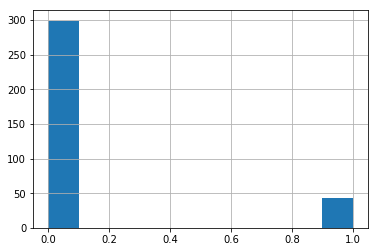

In [21]:
df.murder_binary.hist()

## NOTE: Only 12% of murder_binary is `true`. Meaning we can get 88% accuracy by always guessing `false`.

In [22]:
df.murder_binary.describe()

count   342.000
mean      0.126
std       0.332
min       0.000
25%       0.000
50%       0.000
75%       0.000
max       1.000
Name: murder_binary, dtype: float64

In [23]:
df_2014.murder_binary.describe()

count   363.000
mean      0.124
std       0.330
min       0.000
25%       0.000
50%       0.000
75%       0.000
max       1.000
Name: murder_binary, dtype: float64

## Vanilla regression: worse than guessing on training data, equal on non-trianing data

In [24]:
run_lr(C=1e9, penalty='l2', solver='liblinear')

Intercept
[-2.96311228e-08]
{'Aggravated assault': 1.0000003535294981,
 'Arson3': 1.0000000045497315,
 'Burglary': 1.0000003353383362,
 'Motor vehicle theft': 1.0000000896690417,
 'Population': 0.9998898843495144,
 'Robbery': 1.000000241572428,
 'Violent crime': 1.0000006325555446,
 'larceny_theft': 0.9999993950216132,
 'pop_squared': 1.0000000016574273,
 'property_crime': 0.9999998200287639,
 'rape_binary': 0.9999999951815272}

Test on data it trained on.

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              294  40
1                5   3

 Percentage accuracy
0.868421052631579

Test on data model DIDN'T train on

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              316  39
1                2   6

 Percentage accuracy
0.8870523415977961


## Ridge Logistic (L2): worse than guessing on training data, equal on non-trianing data

In [28]:
run_lr(C=0.01, penalty='l2', solver='liblinear')

Intercept
[-2.96311222e-08]
{'Aggravated assault': 1.000000353529492,
 'Arson3': 1.0000000045497315,
 'Burglary': 1.0000003353383302,
 'Motor vehicle theft': 1.0000000896690402,
 'Population': 0.999889884351477,
 'Robbery': 1.0000002415724238,
 'Violent crime': 1.0000006325555335,
 'larceny_theft': 0.9999993950216242,
 'pop_squared': 1.0000000016574273,
 'property_crime': 0.9999998200287674,
 'rape_binary': 0.9999999951815273}

Test on data it trained on.

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              294  40
1                5   3

 Percentage accuracy
0.868421052631579

Test on data model DIDN'T train on

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              316  39
1                2   6

 Percentage accuracy
0.8870523415977961


## Lasso Logistic (L1): works well, with a slight tendency toward *false negatives* (meaning it lacks "sensitivity)
Also, it doesn't seem to have overfit too much, dropping only 2% accuracy on new data.

## REFLECTION
On this small data set (n=342), only a strong LASSO (l1) penalty produced a model which did anything other than just guess the dominant class. 

Why? Lasso works by trying to drive some coefficients completely to zero.

**I'm trying to understand why this is:** Do we get more significant coefficients because Lasso drives some toward zero (1 here, after they're exponentiated), leaving space for other coefficients to have more predictive power, such as `Violent Crime` and `Aggravated assault`?

I also tried usng `lbfgs` (which only works on L2), which just guessed `0` every time, even with an L2 penalty. I'm guessing this is because liblinear is better for smaller datasets (per documentation)?

In [36]:
run_lr(C=0.48, penalty='l1', solver='liblinear')

Intercept
[-3.89055619]
{'Aggravated assault': 0.777600110640017,
 'Arson3': 1.0683795621176184,
 'Burglary': 1.0004011837094438,
 'Motor vehicle theft': 0.9692148333568493,
 'Population': 1.0001228073804802,
 'Robbery': 0.8060321743479357,
 'Violent crime': 1.281363715945837,
 'larceny_theft': 0.9998200595440578,
 'pop_squared': 0.9999999988986237,
 'property_crime': 0.9995069996975908,
 'rape_binary': 1.0}

Test on data it trained on.

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              298  25
1                1  18

 Percentage accuracy
0.9239766081871345

Test on data model DIDN'T train on

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              308  23
1               10  22

 Percentage accuracy
0.9090909090909091


## ... but what if the *penalty's* strength is almost completely minimized?

### Still works better than `L2`... Why? Is it just the approach in general isolates certain predictive variables even when the effect of the penalty is small?

In [27]:
run_lr(C=1e9, penalty='l1', solver='liblinear')

Intercept
[-4.54033932]
{'Aggravated assault': 0.7503902684067778,
 'Arson3': 1.1269456371565847,
 'Burglary': 1.0000251374348403,
 'Motor vehicle theft': 0.9633416304114747,
 'Population': 1.0001411925464034,
 'Robbery': 0.7831631061788892,
 'Violent crime': 1.3242752233078745,
 'larceny_theft': 0.9999184124931597,
 'pop_squared': 0.9999999987471062,
 'property_crime': 0.9992168542989998,
 'rape_binary': 1.6537865364809796}

Test on data it trained on.

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              296  24
1                3  19

 Percentage accuracy
0.9210526315789473

Test on data model DIDN'T train on

 Accuracy by admission status
murder_binary    0   1
row_0                 
0              307  26
1               11  19

 Percentage accuracy
0.8980716253443526
